<a href="https://colab.research.google.com/github/abhilash1910/Accelerated_Deep_Learning/blob/master/Torch_JIT_Tracing_BERT_Large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers


In [2]:
!nvidia-smi

Sat Jun 18 06:07:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


BERT large loading from HF standard template

In [26]:
#Standard BERT dummy from HF
from transformers import BertModel, BertTokenizer, BertConfig
import torch

enc = BertTokenizer.from_pretrained("bert-large-uncased")

# Tokenizing input text
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = enc.tokenize(text)

# Masking one of the input tokens
masked_index = 8
tokenized_text[masked_index] = "[MASK]"
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Creating a dummy input
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
dummy_input = [tokens_tensor, segments_tensors]

# Initializing the model with the torchscript flag
# Flag set to True even though it is not necessary as this model does not have an LM Head.
config = BertConfig(
    vocab_size_or_config_json_file=32000,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    torchscript=True,
)

# Instantiating the model
model = BertModel(config)

# The model needs to be in evaluation mode
model.eval()

# If you are instantiating the model with *from_pretrained* you can also easily set the TorchScript flag
model = BertModel.from_pretrained("bert-large-uncased", torchscript=True)



Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Convert model to Torch JIT 

In [27]:
# Creating the trace
model.to("cpu")
traced_model = torch.jit.trace(model, [tokens_tensor, segments_tensors])
torch.jit.save(traced_model, "traced_bert.pt")

In [ ]:
traced_model

In [30]:
!pip install timer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Export weights to CUDA device for both Native BERT large and Jit BERT large

In [43]:

# setup="native_gpu = model.cuda()"
# tokens_tensor_gpu = tokens_tensor.cuda()
# segments_tensors_gpu = segments_tensors.cuda()
# stmt="native_gpu(tokens_tensor_gpu,segments_tensors_gpu)"
# timeit.repeat( stmt, setup, number=1, repeat=10, globals=globals())
from timer import timer
native_gpu = model.cuda()
tokens_tensor_gpu = tokens_tensor.cuda()
segments_tensors_gpu = segments_tensors.cuda()
timer_list=[]
with timer() as t:
  for _ in range(100):
    native_gpu(tokens_tensor_gpu,segments_tensors_gpu)
    timer_list.append(t.elapse)
    print(f"time taken GPU:{t.elapse}")
print(f"Mean Time on GPU {np.mean(timer_list)}")
native_gpu_mean,native_gpu_std=np.mean(timer_list),np.std(timer_list)

time taken GPU:0.023450054000022647
time taken GPU:0.04704280000032668
time taken GPU:0.06928185700007816
time taken GPU:0.0923203239999566
time taken GPU:0.1140824590002012
time taken GPU:0.1347084190001624
time taken GPU:0.15618186900019282
time taken GPU:0.17665664000014658
time taken GPU:0.19668734500010032
time taken GPU:0.217795851000119
time taken GPU:0.2420310310003515
time taken GPU:0.2633946930000093
time taken GPU:0.28492573400035326
time taken GPU:0.3061101140001483
time taken GPU:0.32774900100002924
time taken GPU:0.3510819390003235
time taken GPU:0.3723013900003025
time taken GPU:0.3940775040000517
time taken GPU:0.4161324050000985
time taken GPU:0.43655806600008873
time taken GPU:0.4608281620003254
time taken GPU:0.4825603920003232
time taken GPU:0.503770361000079
time taken GPU:0.5241934350001429
time taken GPU:0.5457109960002526
time taken GPU:0.5660439319999568
time taken GPU:0.5874045570003545
time taken GPU:0.6077456860002712
time taken GPU:0.628186598999946
time ta

In [44]:
traced_model_gpu = torch.jit.trace(traced_model.cuda(), [tokens_tensor.cuda(), segments_tensors.cuda()])
with timer() as t:
  for _ in range(100):
    traced_model_gpu(tokens_tensor_gpu,segments_tensors_gpu)
    timer_list.append(t.elapse)
    print(f"time taken traced model GPU:{t.elapse}")
print(f"Mean Time Traced Model on GPU {np.mean(timer_list)}")
traced_model_gpu_mean,traced_model_gpu_std=np.mean(timer_list),np.std(timer_list)

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:736: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  "The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is."


time taken traced model GPU:0.015598941000007471
time taken traced model GPU:0.03234528599978148
time taken traced model GPU:0.049356176999936
time taken traced model GPU:0.0689895269997578
time taken traced model GPU:0.08206378800014136
time taken traced model GPU:0.09437793200004307
time taken traced model GPU:0.10664279499997065
time taken traced model GPU:0.11957215999973414
time taken traced model GPU:0.13262462100010453
time taken traced model GPU:0.1462258430001384
time taken traced model GPU:0.15910816399991745
time taken traced model GPU:0.17157254999983707
time taken traced model GPU:0.1840195589998075
time taken traced model GPU:0.19643460999986928
time taken traced model GPU:0.21171923300016715
time taken traced model GPU:0.22663808800007246
time taken traced model GPU:0.23871973399991475
time taken traced model GPU:0.2512184019997221
time taken traced model GPU:0.2650144320000436
time taken traced model GPU:0.2787801629997375
time taken traced model GPU:0.29274012699988816

Estimate mean and std for 100 runs .Differences pronounced in more runs

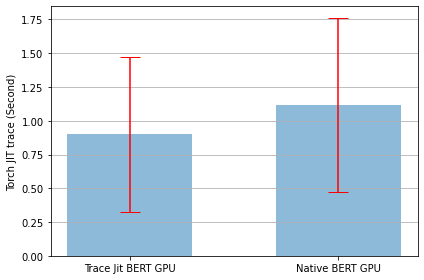

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
import numpy as np
def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('Torch JIT trace (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_name)
    plt.close(fig)


plot([traced_model_gpu_mean,native_gpu_mean],
     [traced_model_gpu_std, native_gpu_std],
     ['Trace Jit BERT GPU', 'Native BERT GPU'],
     'trace_vs_bert_gpu.png')

In [49]:
native_model_cpu=native_gpu.to("cpu")
traced_model_cpu=traced_model_gpu.to("cpu")
timer_list=[]
with timer() as t:
  for _ in range(100):
    traced_model_cpu(tokens_tensor,segments_tensors)
    timer_list.append(t.elapse)
    #print(f"time taken traced model CPU:{t.elapse}")
print(f"Mean Time Traced Model on CPU {np.mean(timer_list)}")
traced_model_cpu_mean,traced_model_cpu_std=np.mean(timer_list),np.std(timer_list)
timer_list=[]
with timer() as t:
  for _ in range(100):
    native_model_cpu(tokens_tensor,segments_tensors)
    timer_list.append(t.elapse)
    #print(f"time taken traced model CPU:{t.elapse}")
print(f"Mean Time Native Model on CPU {np.mean(timer_list)}")
native_cpu_mean,native_cpu_std=np.mean(timer_list),np.std(timer_list)

Mean Time Traced Model on CPU 17.975117748420452
Mean Time Native Model on CPU 18.122856914840305


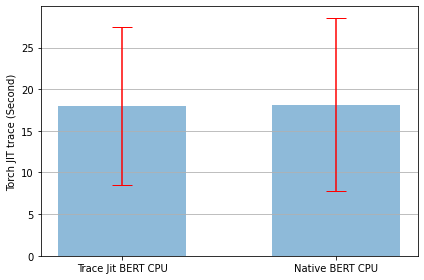

<Figure size 432x288 with 0 Axes>

In [50]:

plot([traced_model_cpu_mean,native_cpu_mean],
     [traced_model_cpu_std, native_cpu_std],
     ['Trace Jit BERT CPU', 'Native BERT CPU'],
     'trace_vs_bert_cpu.png')

In [ ]:
# import numpy as np
# import timeit
# setup="""loaded_model = torch.jit.load("traced_bert.pt")"""
# stmt="loaded_model.eval()"
# run_time_traced=timeit.repeat( stmt, setup, number=1, repeat=10, globals=globals())
# trace_mean, trace_std = np.mean(run_time_traced), np.std(run_time_traced)
# run_time_traced
# torch.save(model,'orig_model.pt')
# setup="""loaded_model_o = torch.load("orig_model.pt")"""
# stmt="loaded_model_o.eval()"
# run_time_orig=timeit.repeat( stmt, setup, number=1, repeat=10, globals=globals())
# rn_mean, rn_std = np.mean(run_time_orig), np.std(run_time_orig)
# run_time_orig
# overhead_tracing= abs(trace_mean/rn_mean)-1
# print(f"{overhead_tracing}% time wasted in  io loading with jit ")